In [1]:
import os
import random

import numpy as np
import torch


def seed_everything(seed: int,
                    use_deterministic_algos: bool = False) -> None:
    
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(use_deterministic_algos)
    random.seed(seed)
    
random_state = 42    
seed_everything(random_state)

In [2]:
from torch.utils.data import Dataset
import cv2


class SouthParkDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.paths = []
        self.labels = []
        self.label_ids = []
        
        for i, (dir, subdir, files) in enumerate(os.walk(self.root_dir)):
            for file in files:
                self.paths.append(os.path.join(dir, file))
                self.labels.append(dir)
                self.label_ids.append(i - 1)

        self.num_classes = len(set(self.label_ids))
        self.class2id = dict(map(lambda i,j : (i,j), self.labels, self.label_ids))
        self.id2class = dict(map(lambda i,j : (i,j), self.label_ids, self.labels))

    @staticmethod
    def __read_img(path) -> torch.Tensor:
        image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        return image
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = self.__read_img(self.paths[idx])
        label = self.label_ids[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
dataset = SouthParkDataset(root_dir="../single_character_data_old", transform=None)
len(dataset), dataset.num_classes

(906, 20)

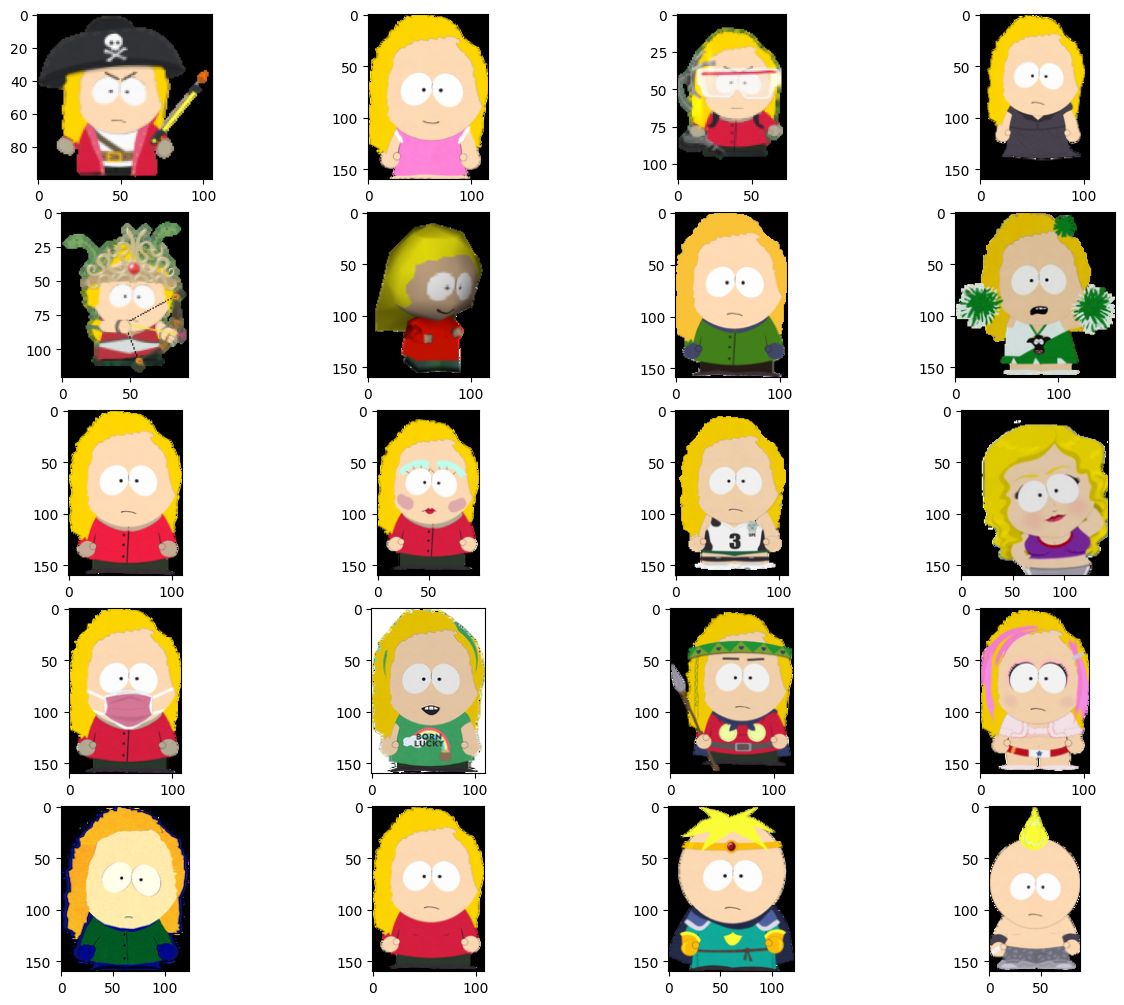

In [4]:
import torch
import torchvision
import matplotlib.pyplot as plt


def show_images(dataset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    for i, (img, label) in enumerate(dataset):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img)



show_images(dataset)

In [5]:
import torch.nn.functional as F

In [6]:
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 32
BATCH_SIZE = 32


def load_transformed_dataset():
    data_transforms = transforms.Compose([
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        # transforms.RandomHorizontalFlip(),
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ])

    dataset = SouthParkDataset(root_dir="../single_character_data", transform=data_transforms)
    
    return dataset


def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0]
        
    plt.imshow(reverse_transforms(image))

    
train_dataset = load_transformed_dataset()
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [7]:
train_dataset.num_classes

20

/home/leffff/PycharmProjects/south-park-character-generation/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


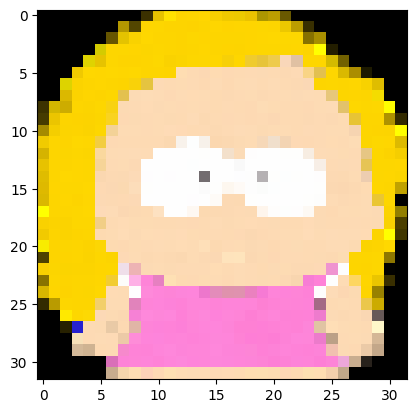

In [8]:
show_tensor_image(train_dataset[0][0])

In [9]:
!git clone https://github.com/openai/improved-diffusion
!mv improved-diffusion/improved_diffusion ./

fatal: destination path 'improved-diffusion' already exists and is not an empty directory.
mv: cannot stat 'improved-diffusion/improved_diffusion': No such file or directory


In [10]:
! pip install -e improved-diffusion

Obtaining file:///home/leffff/PycharmProjects/south-park-character-generation/models/improved-diffusion
  Preparing metadata (setup.py) ... done
  Attempting uninstall: improved-diffusion
    Found existing installation: improved-diffusion 0.0.0
    Uninstalling improved-diffusion-0.0.0:
      Successfully uninstalled improved-diffusion-0.0.0
  Running setup.py develop for improved-diffusion

[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


In [10]:
from improved_diffusion.unet import UNetModel

model = UNetModel(
    num_classes=train_dataset.num_classes,
    in_channels=3, 
    model_channels=32, 
    out_channels=3,
    num_res_blocks=3,
    attention_resolutions=("16",)
)
model

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (label_emb): Embedding(20, 128)
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-3): 3 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 32, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=128, out_features=32, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 32, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0, inplace=False)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


# Training


In [11]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

/tmp/ipykernel_280678/1746774269.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images + 1, int(idx / stepsize) + 1)


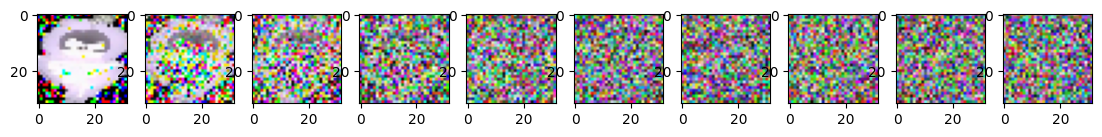

In [12]:
# Simulate forward diffusion
image = next(iter(train_dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T / num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images + 1, int(idx / stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

In [14]:
def get_loss(model, x_0, t, y):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t, y=y)
    return F.mse_loss(noise, noise_pred)

In [15]:
@torch.no_grad()
def sample_timestep(x, t, y):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t, y) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise


@torch.no_grad()
def sample_plot_image(y=None):
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T / num_images)
    if y == None:
        y = torch.randint(0, train_dataset.num_classes, (1,), device=device).long()
    else:
        y = torch.tensor([y], device=device).long()
        
    for i in list(range(0, T))[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t, y)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

  0%|          | 0/29 [00:00<?, ?it/s]

/home/leffff/PycharmProjects/south-park-character-generation/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 0 | step 000 Loss: 1.0054845809936523 


/tmp/ipykernel_280678/131422116.py:49: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


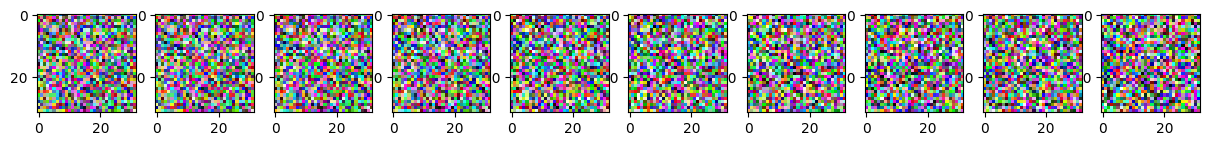

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 5 | step 000 Loss: 0.12035022675991058 


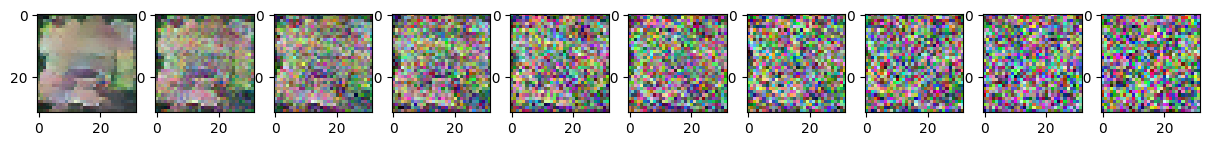

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 10 | step 000 Loss: 0.17107880115509033 


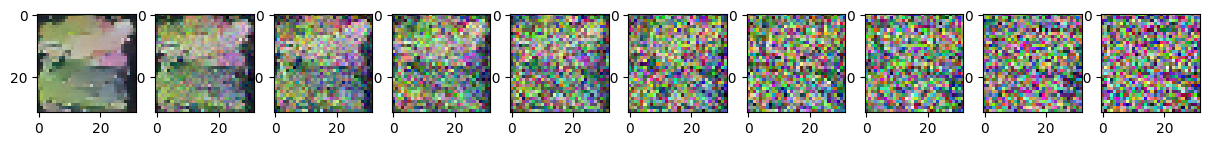

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 15 | step 000 Loss: 0.14021961390972137 


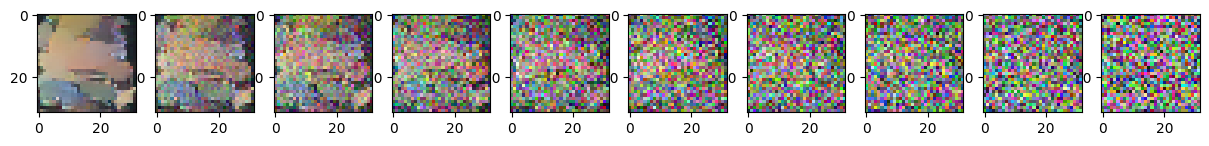

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 20 | step 000 Loss: 0.16849848628044128 


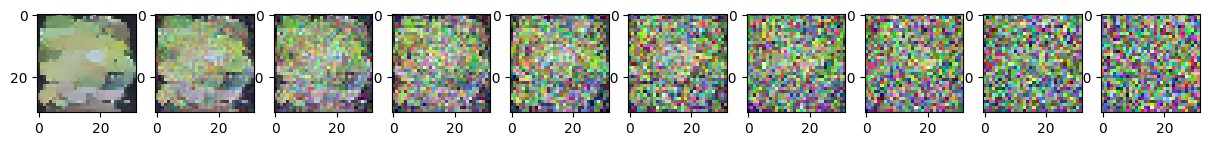

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 25 | step 000 Loss: 0.10090343654155731 


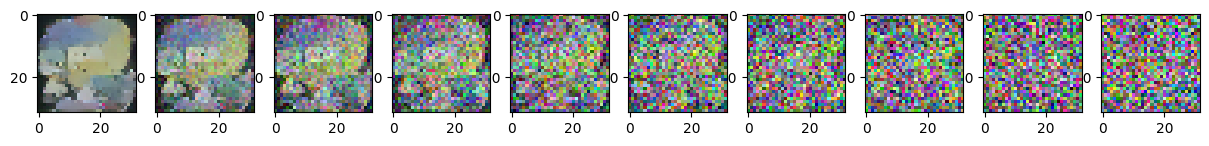

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 30 | step 000 Loss: 0.11373432725667953 


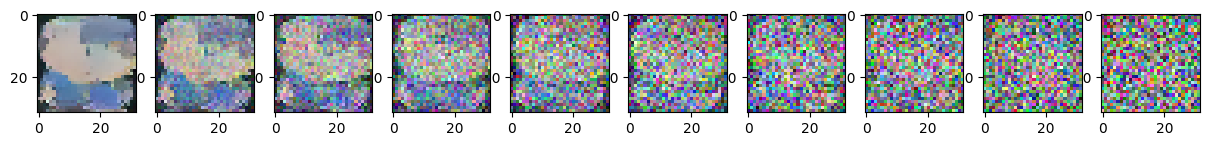

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 35 | step 000 Loss: 0.09981606900691986 


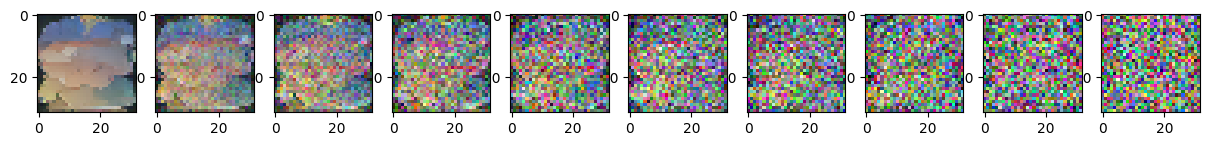

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 40 | step 000 Loss: 0.05827638506889343 


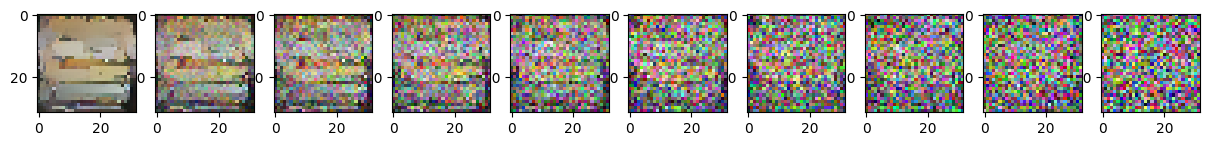

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 45 | step 000 Loss: 0.08131452649831772 


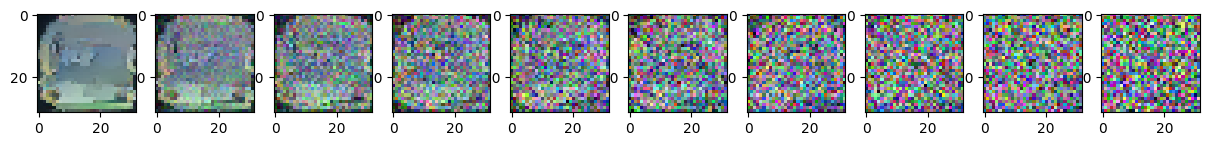

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 50 | step 000 Loss: 0.08994877338409424 


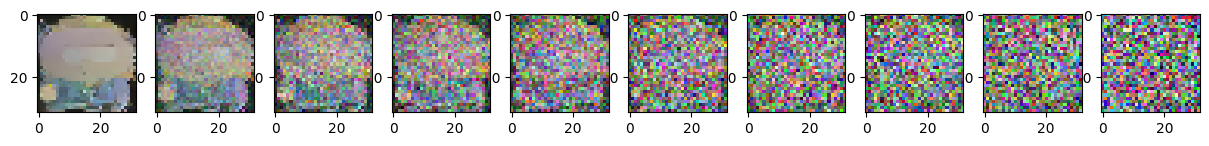

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 55 | step 000 Loss: 0.09091909974813461 


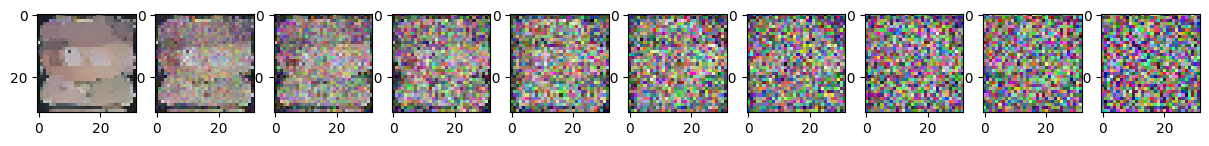

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 60 | step 000 Loss: 0.0811096653342247 


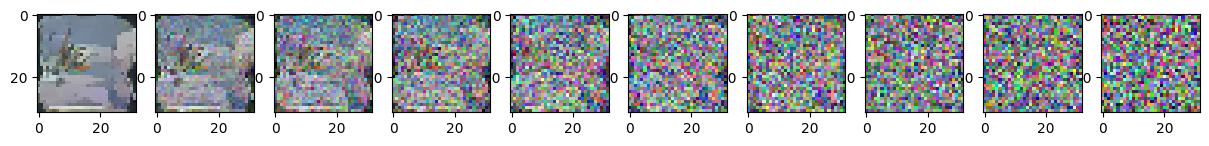

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 65 | step 000 Loss: 0.07328241318464279 


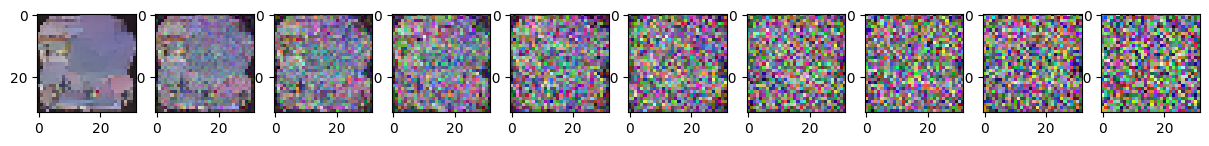

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 70 | step 000 Loss: 0.07803669571876526 


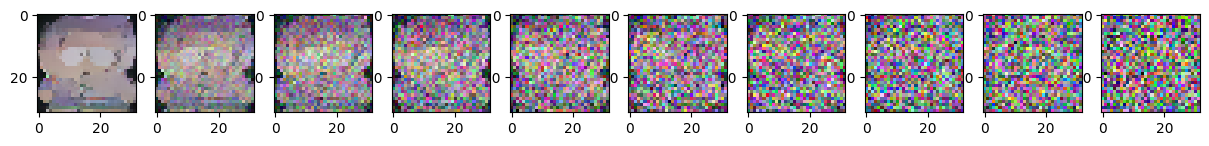

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 75 | step 000 Loss: 0.08152078837156296 


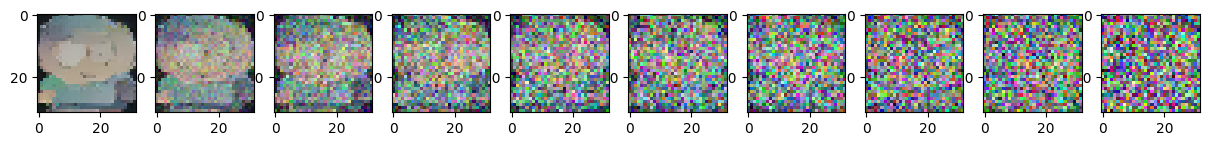

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 80 | step 000 Loss: 0.0940568670630455 


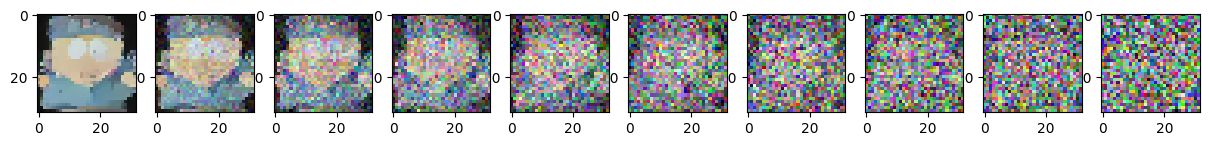

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 85 | step 000 Loss: 0.07717569172382355 


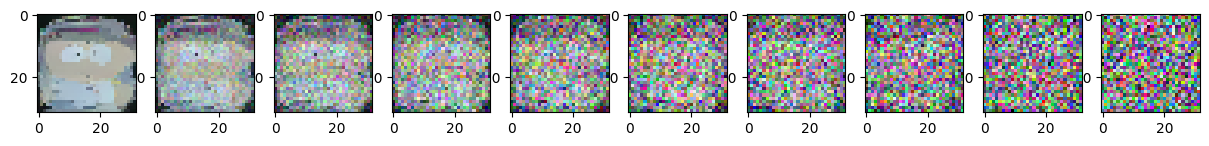

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 90 | step 000 Loss: 0.092540442943573 


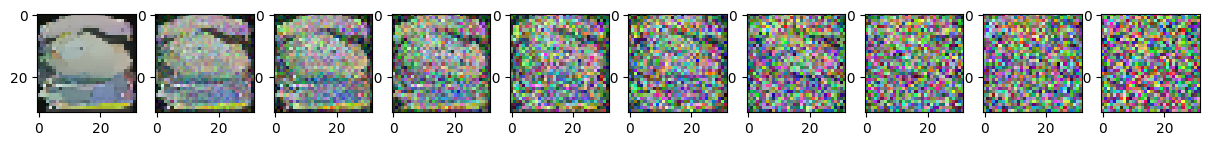

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 95 | step 000 Loss: 0.07427962124347687 


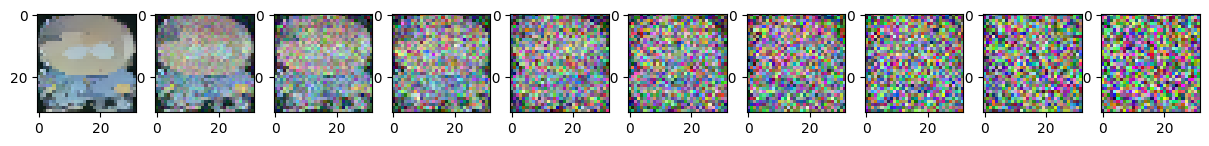

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

In [16]:
from torch.optim import Adam
from tqdm.auto import tqdm

device = "cuda"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!

for epoch in range(epochs):
    step = 0
    for batch in tqdm(train_dataloader):
        x_0, y = batch
        x_0, y = x_0.to(device), y.to(device)
        optimizer.zero_grad()
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model, x_0, t, y)
        loss.backward()
        optimizer.step()

        if epoch % 5 == 0 and step == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            sample_plot_image()
            torch.save(model, f"model_{epoch}.pt")

        step += 1

# Sampling

Lets sample Kyle Broflovski

In [17]:
train_dataset.class2id

{'../single_character_data/Bebe_Stevens': 0,
 '../single_character_data/Butters_Stotch': 1,
 '../single_character_data/Karen_McCormick': 2,
 '../single_character_data/Pip_Pirrip': 3,
 '../single_character_data/Kyle_Broflovski': 4,
 '../single_character_data/Clyde_Donovan': 5,
 '../single_character_data/Kevin_Stoley': 6,
 '../single_character_data/Timmy_Burch': 7,
 '../single_character_data/Bradley_Biggle': 8,
 '../single_character_data/Kenny_McCormick': 9,
 '../single_character_data/Tweek_Tweak': 10,
 '../single_character_data/Tolkien_Black': 11,
 '../single_character_data/Wendy_Testaburger': 12,
 '../single_character_data/Stan_Marsh': 13,
 '../single_character_data/Heidi_Turner': 14,
 '../single_character_data/Jimmy_Valmer': 15,
 '../single_character_data/Craig_Tucker': 16,
 '../single_character_data/Eric_Cartman': 17,
 '../single_character_data/Terrance_Mephesto': 18,
 '../single_character_data/Shelley_Marsh': 19}

/tmp/ipykernel_280678/131422116.py:49: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


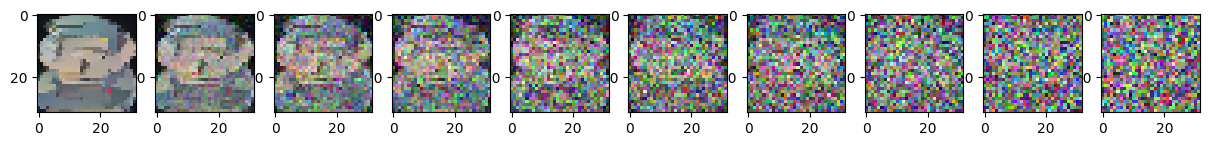

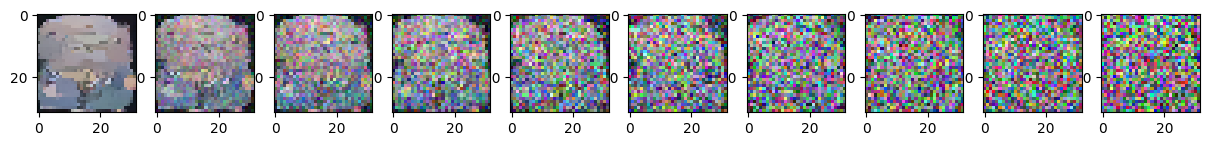

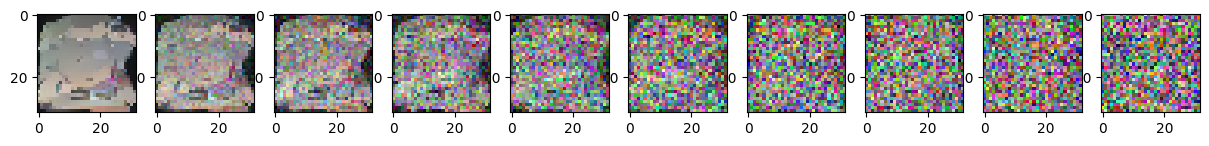

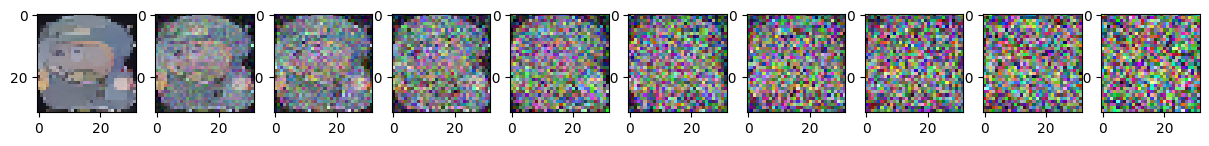

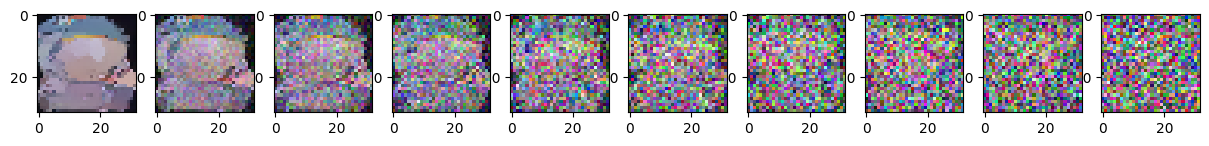

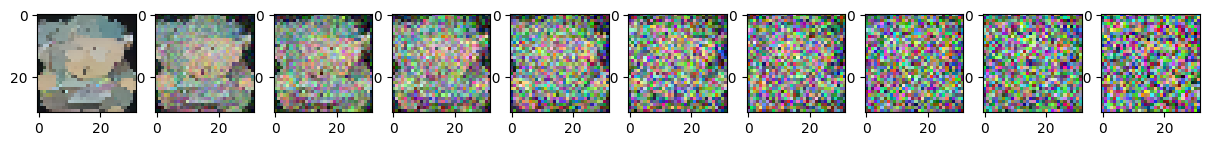

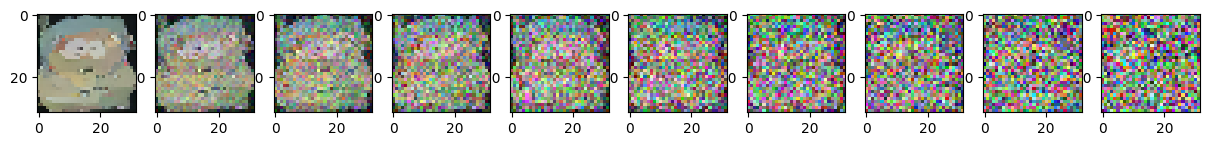

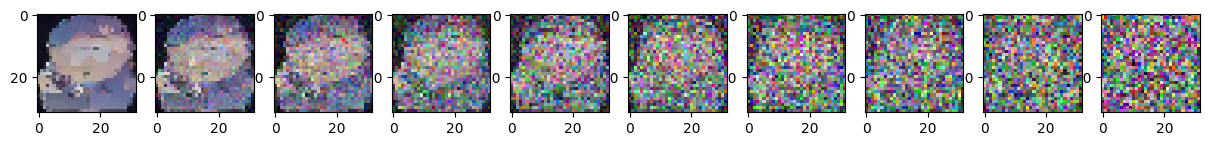

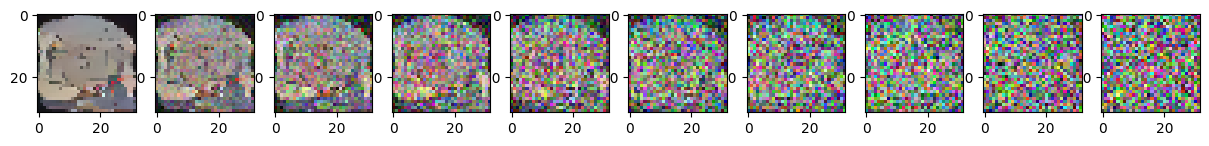

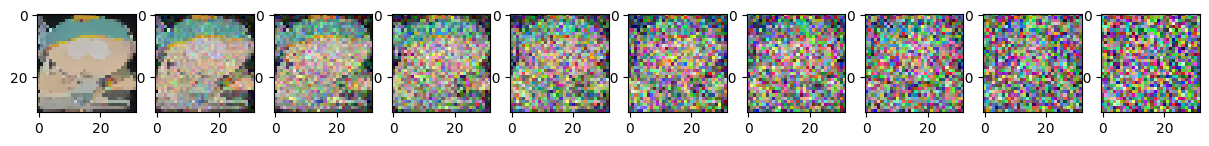

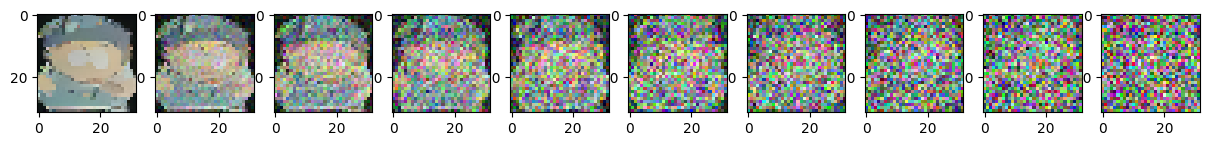

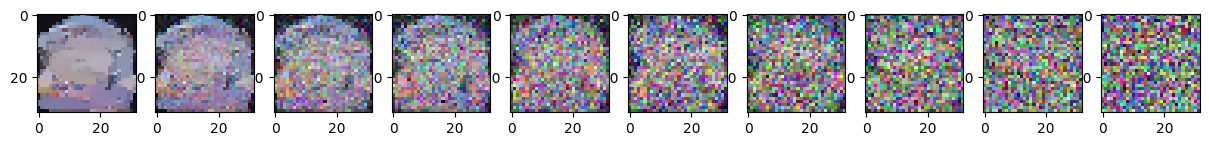

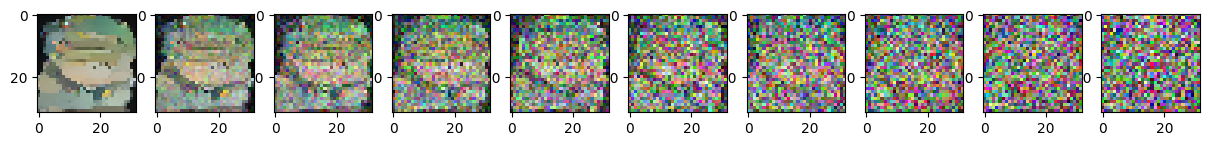

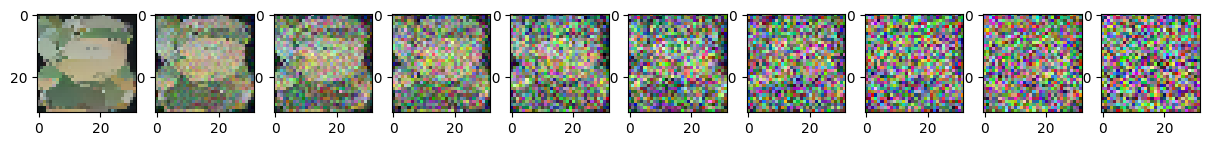

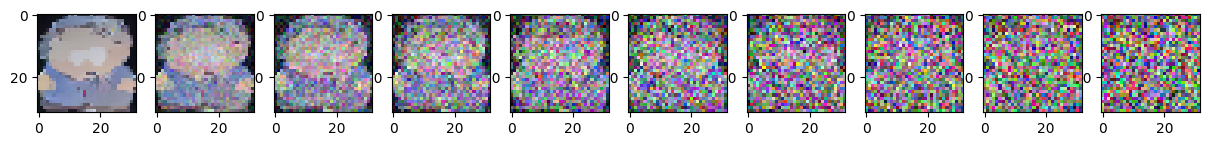

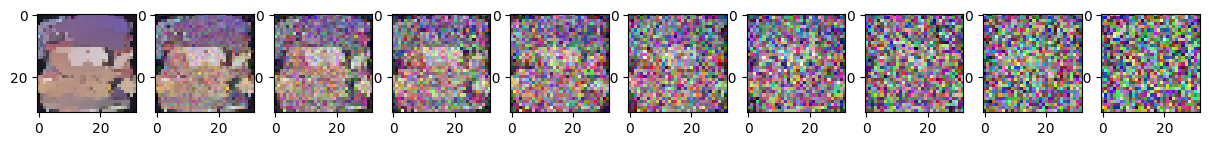

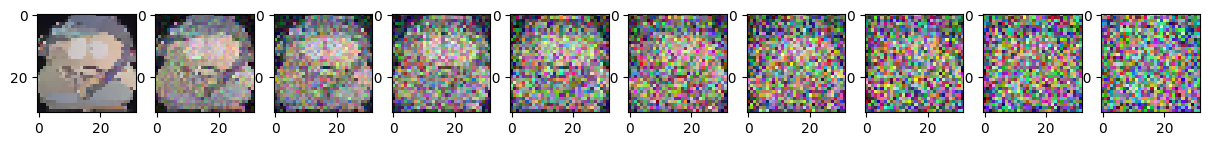

In [ ]:
for i in range(20):
    sample_plot_image(y=17)